### MOREIRA TEIXEIRA Luiz Fernando

# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD)).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule).

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

try:
  import google.colab
  IN_COLAB = True
  print('You are using Google Colab')
  !pip install googledrivedownloader
  from googledrivedownloader import download_file_from_google_drive
except:
  IN_COLAB = False

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

Then load the data from my Google Drive

In [2]:
if IN_COLAB:
  download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
  dest_path='./data/features.csv')
  download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/im/nevus-seg.jpg')
  download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/im/nevus.jpg')
  download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/im/melanoma-seg.jpg')
  download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data

In [3]:
## Read data
Working_directory="./data/"
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


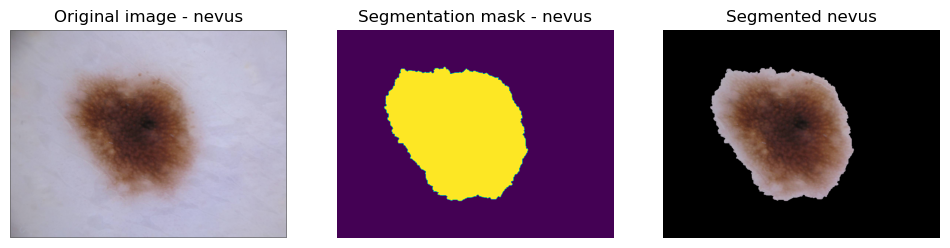

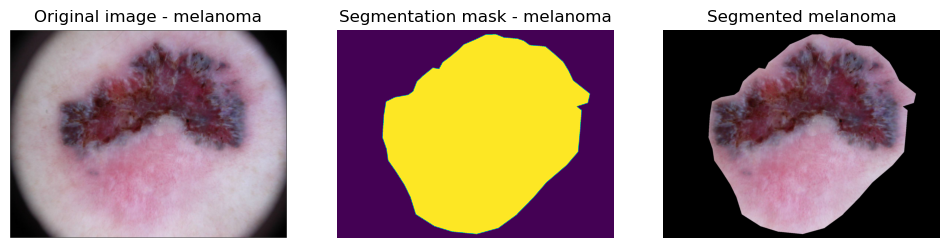

In [4]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg')
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")
plt.show()

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg')
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")
plt.show()

Now, as in the previous practical session you should shuffle the data randomly

In [5]:
# Shuffle data randomly
indeces = np.arange(len(X))
np.random.shuffle(indeces)
Xp = X[indeces]
yp= y[indeces]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

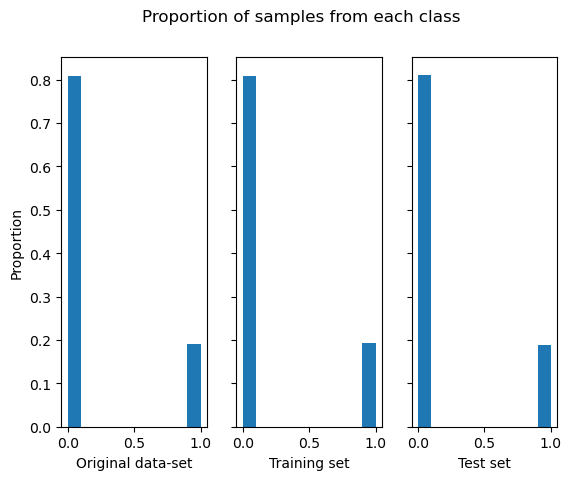

In [6]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')
plt.show()

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

**Answer:**

When scaling your features, you must fit the scaler only on the training set (i.e. compute the training set’s mean and variance) and then use these parameters to transform the test set. This prevents data leakage from the test set and ensures that your model's evaluation is fair and reflects performance on unseen data.

In [7]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices.

**Question**: Comment the results.

**Answer:**

Both algorithms dont perform very well since even though 'healthy' is being correctly classified (90% LDA and 92% QDA) melanoma is being missclassified most of the time, being correctly classified only at (29% LDA and 32% QDA). 

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


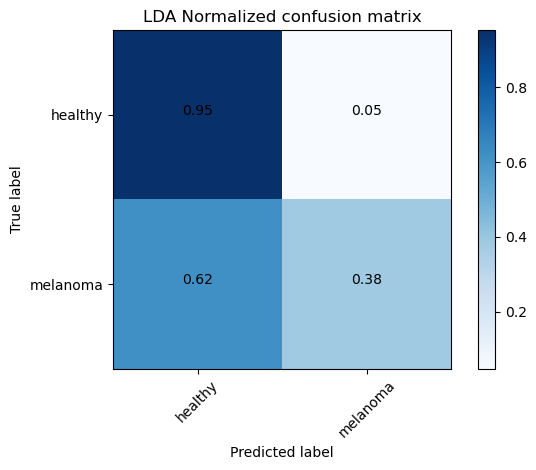

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       146
           1       0.52      0.35      0.42        34

    accuracy                           0.82       180
   macro avg       0.69      0.64      0.66       180
weighted avg       0.80      0.82      0.80       180

Normalized confusion matrix
[[0.92465753 0.07534247]
 [0.64705882 0.35294118]]


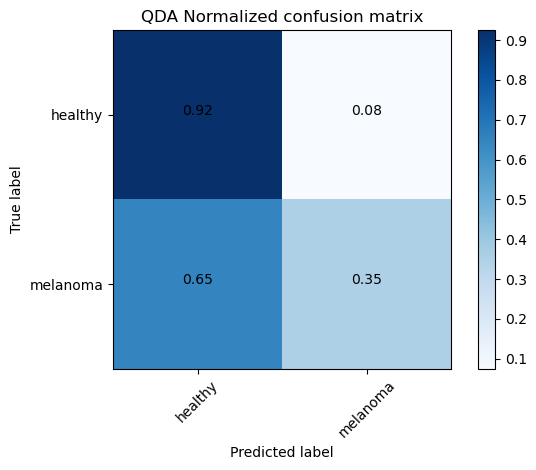

In [8]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Answer:**

Instead of relying on a single train/test split, which can lead to biased performance estimates, we can use k-fold cross-validation to average results over different data splits and obtain a more robust estimate of your model's generalization ability.

In [9]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_score = cross_val_score(lda,X=X_train, y=y_train,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_score = cross_val_score(qda,X=X_train, y=y_train,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour

print("Fitting KNN")
t0 = time()
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
neigh_score = cross_val_score(neigh, X=X_train, y=y_train,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))



Fitting LDA
done in 0.028s
 Average and std CV score : 0.7976190476190477 +- 0.03194382824999703
Fitting QDA
done in 0.026s
 Average and std CV score : 0.8023809523809524 +- 0.012140522651411379
Fitting KNN
done in 0.053s
 Average and std CV score : 0.8023809523809524 +- 0.034992710611188256


---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation.

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

**Answer:**

We can notice that almost 92% of the healthy cases are correctly identified, but only around 18% of the melanoma cases are correctly classified. This huge imbalance indicates that the classifier is heavily biased toward predicting the majority class, healthy, likely because the dataset is imbalanced with many more healthy samples than melanoma ones. In other words, when the classifier looks for the 4 nearest neighbors, it mostly finds healthy examples, which makes it difficult to correctly classify the rarer melanoma cases.

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8214285714285715
Best training params: {'kneighborsclassifier__n_neighbors': 6}
Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.73529412 0.26470588]]


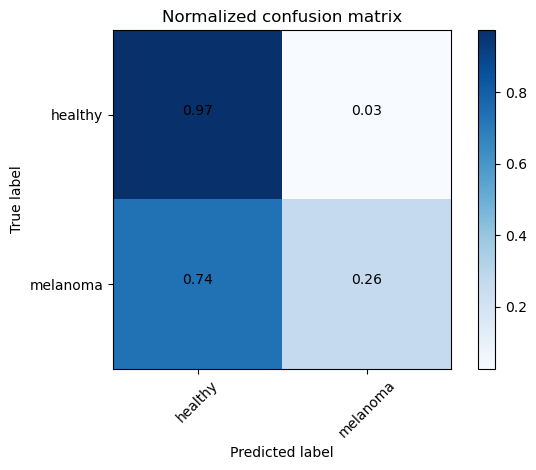

In [10]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions.

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.3941176470588236
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.83561644 0.16438356]
 [0.5        0.5       ]]


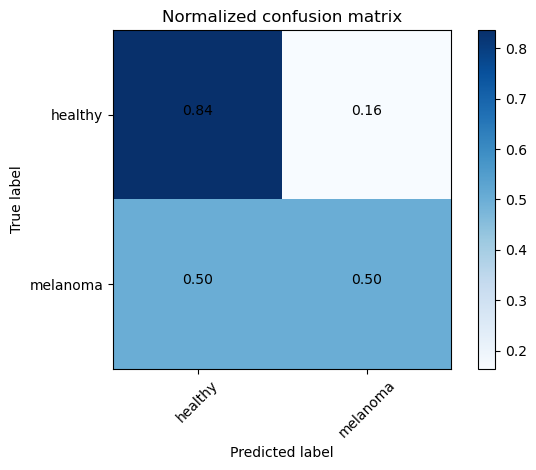

In [11]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="recall", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage.

**Answer:**

Since we have an imbalanced dataset with more healthy class than melanoma we should do an oversample of melanoma in order to achieve a balance. By oversampling we create new synthetic examples, helping the model to learn better.

In [12]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 353)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set.

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

**Answer:** 

By oversampling the melanoma class using ADASYN, we synthesize new minority class examples, which helps balance the training data. This improvement is clearly reflected in the cross-validation and confusion matrix results: when using recall as the scoring metric, grid search selects 1 nearest neighbor and we see a more balanced performance of about 68% of healthy cases and nearly 62% of melanoma cases are correctly classified on the test set. In contrast, without oversampling the classifier was heavily biased toward the majority class, misclassifying most melanoma cases. Changing the scoring function to 'recall' shifts the optimization focus toward correctly identifying the minority class, which is crucial when classes are imbalanced.

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.9887323943661972
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.70547945 0.29452055]
 [0.38235294 0.61764706]]


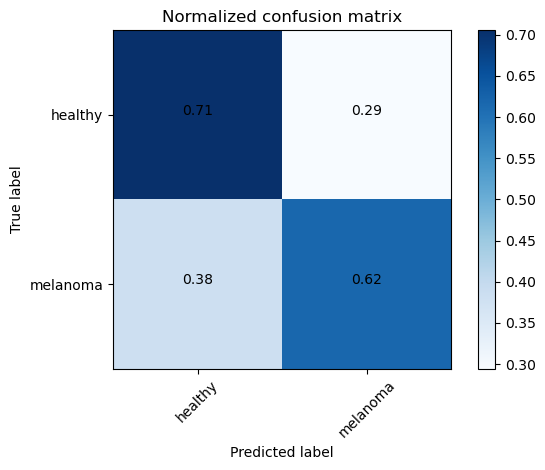

In [13]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="recall", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use the techniques seen today: Perceptron and linear SVM.

In [14]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7962499999999999 +- 0.01113365767990616
 Average and std TEST CV accuracy : 0.7516666666666667 +- 0.030459444804161764
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8458333333333334 +- 0.008838834764831813
 Average and std TEST CV accuracy : 0.8150000000000001 +- 0.035512126254437525


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [15]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7962499999999999 +- 0.01113365767990616
 Average and std TEST CV accuracy : 0.7516666666666667 +- 0.030459444804161764
 Average and std TRAIN CV f1 : 0.40411844830235355 +- 0.12330373336241111
 Average and std TEST CV f1 : 0.2884714623438028 +- 0.12532941678624304
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8458333333333334 +- 0.008838834764831813
 Average and std TEST CV accuracy : 0.8150000000000001 +- 0.035512126254437525
 Average and std TRAIN CV f1 : 0.42558815944848727 +- 0.05150159024146027
 Average and std TEST CV f1 : 0.2984579800099076 +- 0.16101780665211016


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


In [16]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

# Oversampled pipeline with ADASYN for Perceptron
print("Fitting Perceptron with ADASYN oversampling")
Perc_imb = imbalanced_make_pipeline(ADASYN(random_state=0), StandardScaler(), Perceptron())
Perc_cv_imb = cross_validate(Perc_imb, X_train, y_train, cv=5, scoring=('accuracy','f1'), return_train_score=True)
print("Perceptron with ADASYN - Train Accuracy: {:.3f} ± {:.3f}".format(Perc_cv_imb['train_accuracy'].mean(), Perc_cv_imb['train_accuracy'].std()))
print("Perceptron with ADASYN - Test Accuracy: {:.3f} ± {:.3f}".format(Perc_cv_imb['test_accuracy'].mean(), Perc_cv_imb['test_accuracy'].std()))
print("Perceptron with ADASYN - Train F1: {:.3f} ± {:.3f}".format(Perc_cv_imb['train_f1'].mean(), Perc_cv_imb['train_f1'].std()))
print("Perceptron with ADASYN - Test F1: {:.3f} ± {:.3f}".format(Perc_cv_imb['test_f1'].mean(), Perc_cv_imb['test_f1'].std()))

# Oversampled pipeline with ADASYN for Linear SVM
print("\nFitting Linear SVM with ADASYN oversampling")
Lsvm_imb = imbalanced_make_pipeline(ADASYN(random_state=0), StandardScaler(), LinearSVC())
Lsvm_cv_imb = cross_validate(Lsvm_imb, X_train, y_train, cv=5, scoring=('accuracy','f1'), return_train_score=True)
print("Linear SVM with ADASYN - Train Accuracy: {:.3f} ± {:.3f}".format(Lsvm_cv_imb['train_accuracy'].mean(), Lsvm_cv_imb['train_accuracy'].std()))
print("Linear SVM with ADASYN - Test Accuracy: {:.3f} ± {:.3f}".format(Lsvm_cv_imb['test_accuracy'].mean(), Lsvm_cv_imb['test_accuracy'].std()))
print("Linear SVM with ADASYN - Train F1: {:.3f} ± {:.3f}".format(Lsvm_cv_imb['train_f1'].mean(), Lsvm_cv_imb['train_f1'].std()))
print("Linear SVM with ADASYN - Test F1: {:.3f} ± {:.3f}".format(Lsvm_cv_imb['test_f1'].mean(), Lsvm_cv_imb['test_f1'].std()))


Fitting Perceptron with ADASYN oversampling
Perceptron with ADASYN - Train Accuracy: 0.682 ± 0.039
Perceptron with ADASYN - Test Accuracy: 0.621 ± 0.077
Perceptron with ADASYN - Train F1: 0.428 ± 0.048
Perceptron with ADASYN - Test F1: 0.363 ± 0.093

Fitting Linear SVM with ADASYN oversampling
Linear SVM with ADASYN - Train Accuracy: 0.764 ± 0.015
Linear SVM with ADASYN - Test Accuracy: 0.695 ± 0.060
Linear SVM with ADASYN - Train F1: 0.547 ± 0.018
Linear SVM with ADASYN - Test F1: 0.419 ± 0.059


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data.
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data.

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6821428571428572 +- 0.03941177466011151
 Average and std TEST CV accuracy : 0.6214285714285714 +- 0.07656159614673108
 Average and std TRAIN CV f1 : 0.42827695316166725 +- 0.04829439795920674
 Average and std TEST CV f1 : 0.36277313946690776 +- 0.09291082382875379
Normalized confusion matrix
[[0.68493151 0.31506849]
 [0.47058824 0.52941176]]


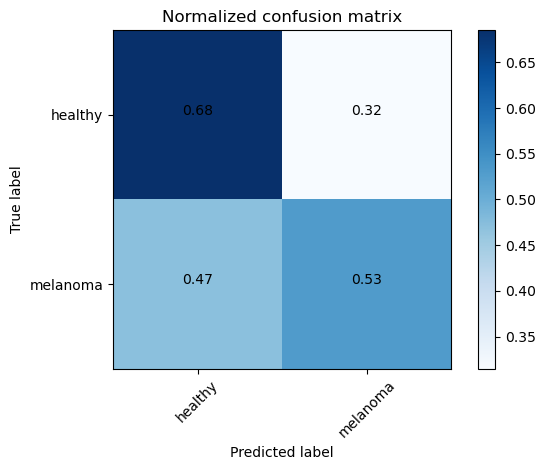

Fitting SVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7642857142857143 +- 0.01533821276991086
 Average and std TEST CV accuracy : 0.6952380952380952 +- 0.06004533434723092
 Average and std TRAIN CV f1 : 0.547017798051243 +- 0.01777991151412007
 Average and std TEST CV f1 : 0.41863146517458283 +- 0.059315091305685685
Normalized confusion matrix
[[0.81506849 0.18493151]
 [0.41176471 0.58823529]]


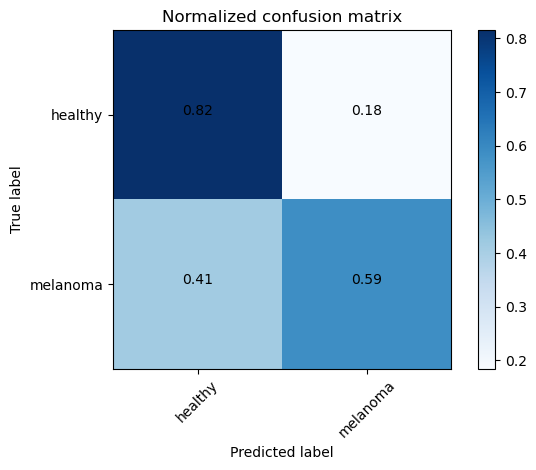

In [17]:
from imblearn.pipeline import make_pipeline as make_pipeline2
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM
print("Fitting SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Lsvm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model.

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.719047619047619
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.76027397 0.23972603]
 [0.38235294 0.61764706]]


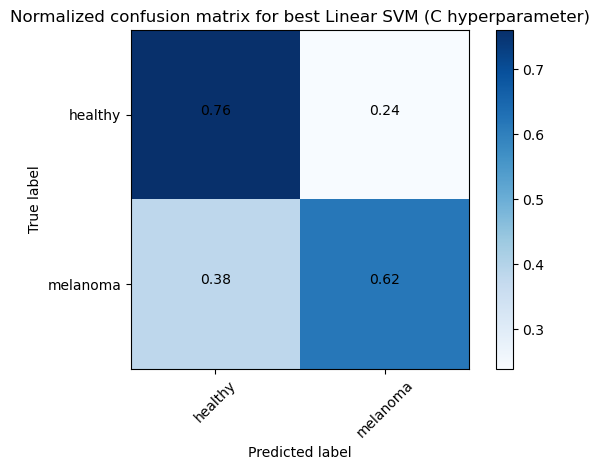

In [18]:
# Looking for the best hyperparameter C using GridSearchCV on oversampled data
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))

# Use the best estimator to predict on the test set
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for best Linear SVM (C hyperparameter)')
plt.show()


Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.8023809523809524
Best training params: {'svc__C': 1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.82352941 0.17647059]]


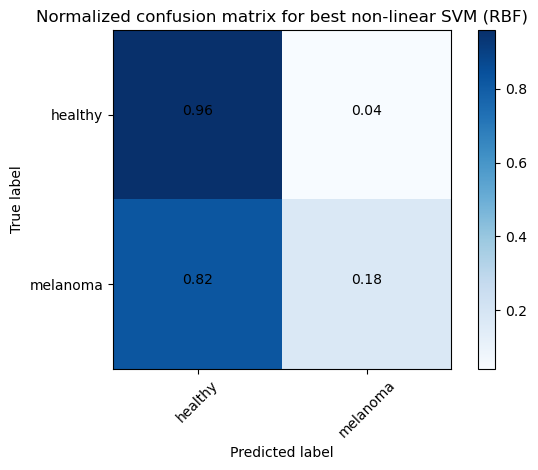

In [19]:
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

y_pred = grid_nlsvm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for best non-linear SVM (RBF)')
plt.show()


**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer:**

When using the non-linear SVM, switching the scoring function from accuracy to recall (and combining it with oversampling) leads to a significant change in performance. With the standard accuracy metric, the non-linear SVM only correctly classifies about 32% of melanoma cases. However, when we change the scoring function to recall—which forces the model to focus on correctly identifying the minority class—the melanoma classification rate increases dramatically to around 62%. This happens because recall gives more importance to the minority class, ensuring that the model doesn't just favor the majority class. In contrast, the linear SVM shows only a slight improvement, indicating that the non-linear model benefits more from tuning with a recall-based metric in this imbalanced scenario.

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer:**

Overall, our experiments show that the best approach for this imbalanced classification problem is to use a non-linear SVM with an RBF kernel, tuned using a recall scoring function and applied on oversampled data. Using recall instead of accuracy as the evaluation metric forces the model to focus on correctly classifying the minority class—melanoma—which is crucial when the classes are unbalanced. In our case, the non-linear SVM’s performance on melanoma detection improved dramatically (from 32% to 62% correct classification) when recall was used and oversampling was applied. While oversampling can sometimes lower overall accuracy because it balances the dataset, it is worth it here since it significantly enhances the detection of the minority class, which is more important in this scenario.


Best training Score: 0.6073529411764705
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.35294118 0.64705882]]


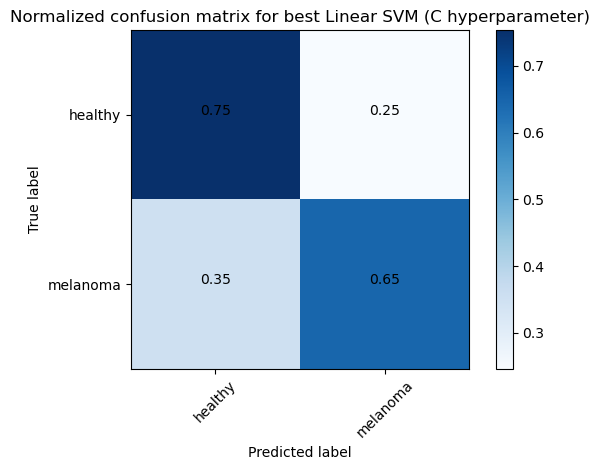

Fitting Non-linear SVM to the training set
Best training Score: 0.6198529411764706
Best training params: {'svc__C': 9, 'svc__gamma': 0.0001}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.35294118 0.64705882]]


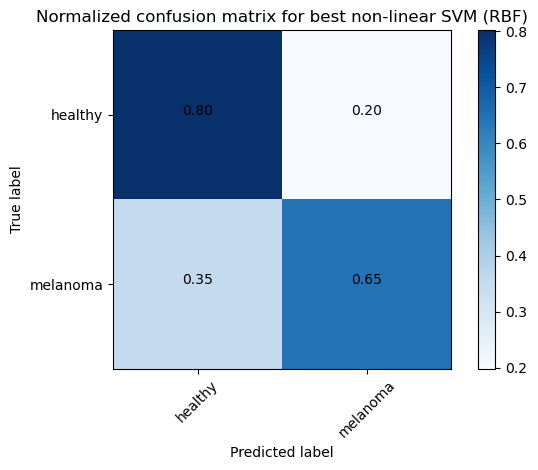

In [20]:
# Looking for the best hyperparameter C using GridSearchCV on oversampled data
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="recall", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))

# Use the best estimator to predict on the test set
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for best Linear SVM (C hyperparameter)')
plt.show()



print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="recall", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

y_pred = grid_nlsvm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for best non-linear SVM (RBF)')
plt.show()


**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [21]:
# Test PCA with a linear SVM
XXXXXXXX

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}

XXXXXXXXXXXXXXXX

NameError: name 'XXXXXXXX' is not defined

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas.

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

XXXXXXXXXX